### The following notebook requires the summit_utils module which is available here: https://github.com/lsst-sitcom/summit_utils.git, be sure to check out branch tickets/DM-31175 and do `setup -j -r` . and `scons -j 4` in the summit_utils directory.

### As of November 3, one needs to run version w_2022_44  of lsst_distrib.

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import lsst.afw.image as afwImage
import glob
from lsst.sitcom import vandv
from astropy.time import Time
from astropy.io import fits
from lsst.summit.utils.blindSolving import blindSolve, chuckHeaderToWcs, headerToWcs, runImchar, genericCameraHeaderToWcs, CommandLineSolver
from lsst.summit.utils.utils import checkStackSetup, getExpPositionOffset
from natsort import natsorted

%matplotlib inline
%env ASTROMETRY_NET_API_KEY=jsnplwndlgndoouk
checkStackSetup()

env: ASTROMETRY_NET_API_KEY=jsnplwndlgndoouk
You are running w_2022_44 of lsst_distrib

Locally setup packages:
-----------------------
summit_utils    at /home/adriansh95/software/summit_utils
notebooks_vandv at /home/adriansh95/notebooks/lsst-sitcom/notebooks_vandv
ts_cRIOpy       at /home/adriansh95/notebooks/lsst-ts/ts_cRIOpy


In [2]:
client = vandv.efd.create_efd_client()

exec_info = vandv.ExecutionInfo()
print(exec_info)


Executed by adriansh95 on 2022-11-17T00:55:44.135.
  Running in yagan08 at summit



### Query EFD for fits urls

In [24]:
date0 = '2022-11-17'
date1 = '2022-11-17'

log_df = await client.select_time_series(
    "lsst.sal.GenericCamera.logevent_largeFileObjectAvailable", 
    "url",
    Time(f"{date0}T00:00:00", format="isot", scale="utc"),
    Time(f"{date1}T23:59:00", format="isot", scale="utc"),
)

gc101_df = log_df[log_df.url.str.contains('GC101')]
gc102_df = log_df[log_df.url.str.contains('GC102')]
print(gc101_df.url.values)
print(gc102_df.url.values)

['https://s3.cp.lsst.org/rubinobs-lfa-cp/GenericCamera/101/2022/11/16/GC101_O_20221116_000004.fits'
 'https://s3.cp.lsst.org/rubinobs-lfa-cp/GenericCamera/101/2022/11/16/GC101_O_20221116_000005.fits'
 'https://s3.cp.lsst.org/rubinobs-lfa-cp/GenericCamera/101/2022/11/16/GC101_O_20221116_000006.fits'
 'https://s3.cp.lsst.org/rubinobs-lfa-cp/GenericCamera/101/2022/11/16/GC101_O_20221116_000007.fits'
 'https://s3.cp.lsst.org/rubinobs-lfa-cp/GenericCamera/101/2022/11/16/GC101_O_20221116_000008.fits'
 'https://s3.cp.lsst.org/rubinobs-lfa-cp/GenericCamera/101/2022/11/16/GC101_O_20221116_000009.fits'
 'https://s3.cp.lsst.org/rubinobs-lfa-cp/GenericCamera/101/2022/11/16/GC101_O_20221116_000010.fits'
 'https://s3.cp.lsst.org/rubinobs-lfa-cp/GenericCamera/101/2022/11/16/GC101_O_20221116_000011.fits'
 'https://s3.cp.lsst.org/rubinobs-lfa-cp/GenericCamera/101/2022/11/16/GC101_O_20221116_000012.fits'
 'https://s3.cp.lsst.org/rubinobs-lfa-cp/GenericCamera/101/2022/11/16/GC101_O_20221116_000013.fits'


In [25]:
homePath = '/home/adriansh95' # Adrian at Summit
dataPath = 'data/starTracker/tmaTests' # Adrian at Summit and USDF
catalogPath = os.path.join(homePath, 'data/starTracker/catalogs')
tmaTestsPath = os.path.join(homePath, dataPath) 
imageDir = 'procFits'
wcsDir = 'wcsFits'
imagePath = os.path.join(tmaTestsPath, imageDir) 
wcsPath = os.path.join(tmaTestsPath, wcsDir)
passPath = os.path.join(wcsPath, 'pass')
failPath = os.path.join(wcsPath, 'fail')
files = glob.glob(os.path.join(imagePath, '*.fits'))
files = natsorted(files)
print(f"Found {len(files)} files")

Found 111 files


### Pick a Camera and file

In [27]:
genCam = 101
expNum = '000014'
searchStr = f'{genCam}.*{expNum}'
fitsURLs = log_df.url[log_df.url.str.contains(searchStr)]
fitsURL = fitsURLs[0]
stemName = os.path.basename(fitsURL).split('.')[0]
cmdStr = f'wget -P {imagePath} {fitsURL}'
fileName = os.path.join(imagePath, f'{stemName}.fits')
if not os.path.exists(fileName):
    os.system(cmdStr)

--2022-11-17 02:29:40--  https://s3.cp.lsst.org/rubinobs-lfa-cp/GenericCamera/101/2022/11/16/GC101_O_20221116_000014.fits
Resolving s3.cp.lsst.org (s3.cp.lsst.org)... 139.229.160.201
Connecting to s3.cp.lsst.org (s3.cp.lsst.org)|139.229.160.201|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16309440 (16M) [binary/octet-stream]
Saving to: ‘/home/adriansh95/data/starTracker/tmaTests/procFits/GC101_O_20221116_000014.fits’

     0K .......... .......... .......... .......... ..........  0%  204M 0s
    50K .......... .......... .......... .......... ..........  0%  101M 0s
   100K .......... .......... .......... .......... ..........  0% 67.7M 0s
   150K .......... .......... .......... .......... ..........  1% 85.2M 0s
   200K .......... .......... .......... .......... ..........  1% 79.7M 0s
   250K .......... .......... .......... .......... ..........  1% 93.4M 0s
   300K .......... .......... .......... .......... ..........  2% 88.8M 0s
   350K .........

### plot image and inspect by eye to verify that no sources appear saturated
### If Inspection is a success, solve using astrometry.net and write the wcs to the pass directory and proceed. Otherwise stop

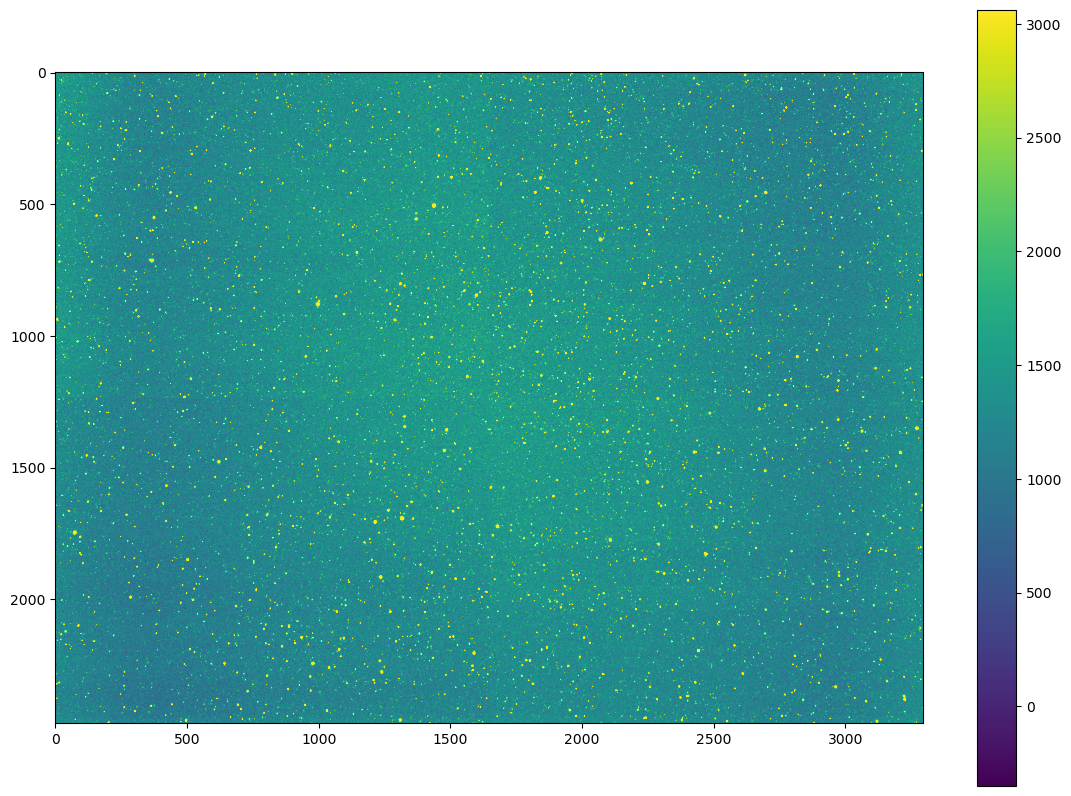

Do any sources look saturated? (y/n) n


Found 592 sources, 592 bright sources
Brightest centroid at (367.4335763372523, 715.2156474246758)


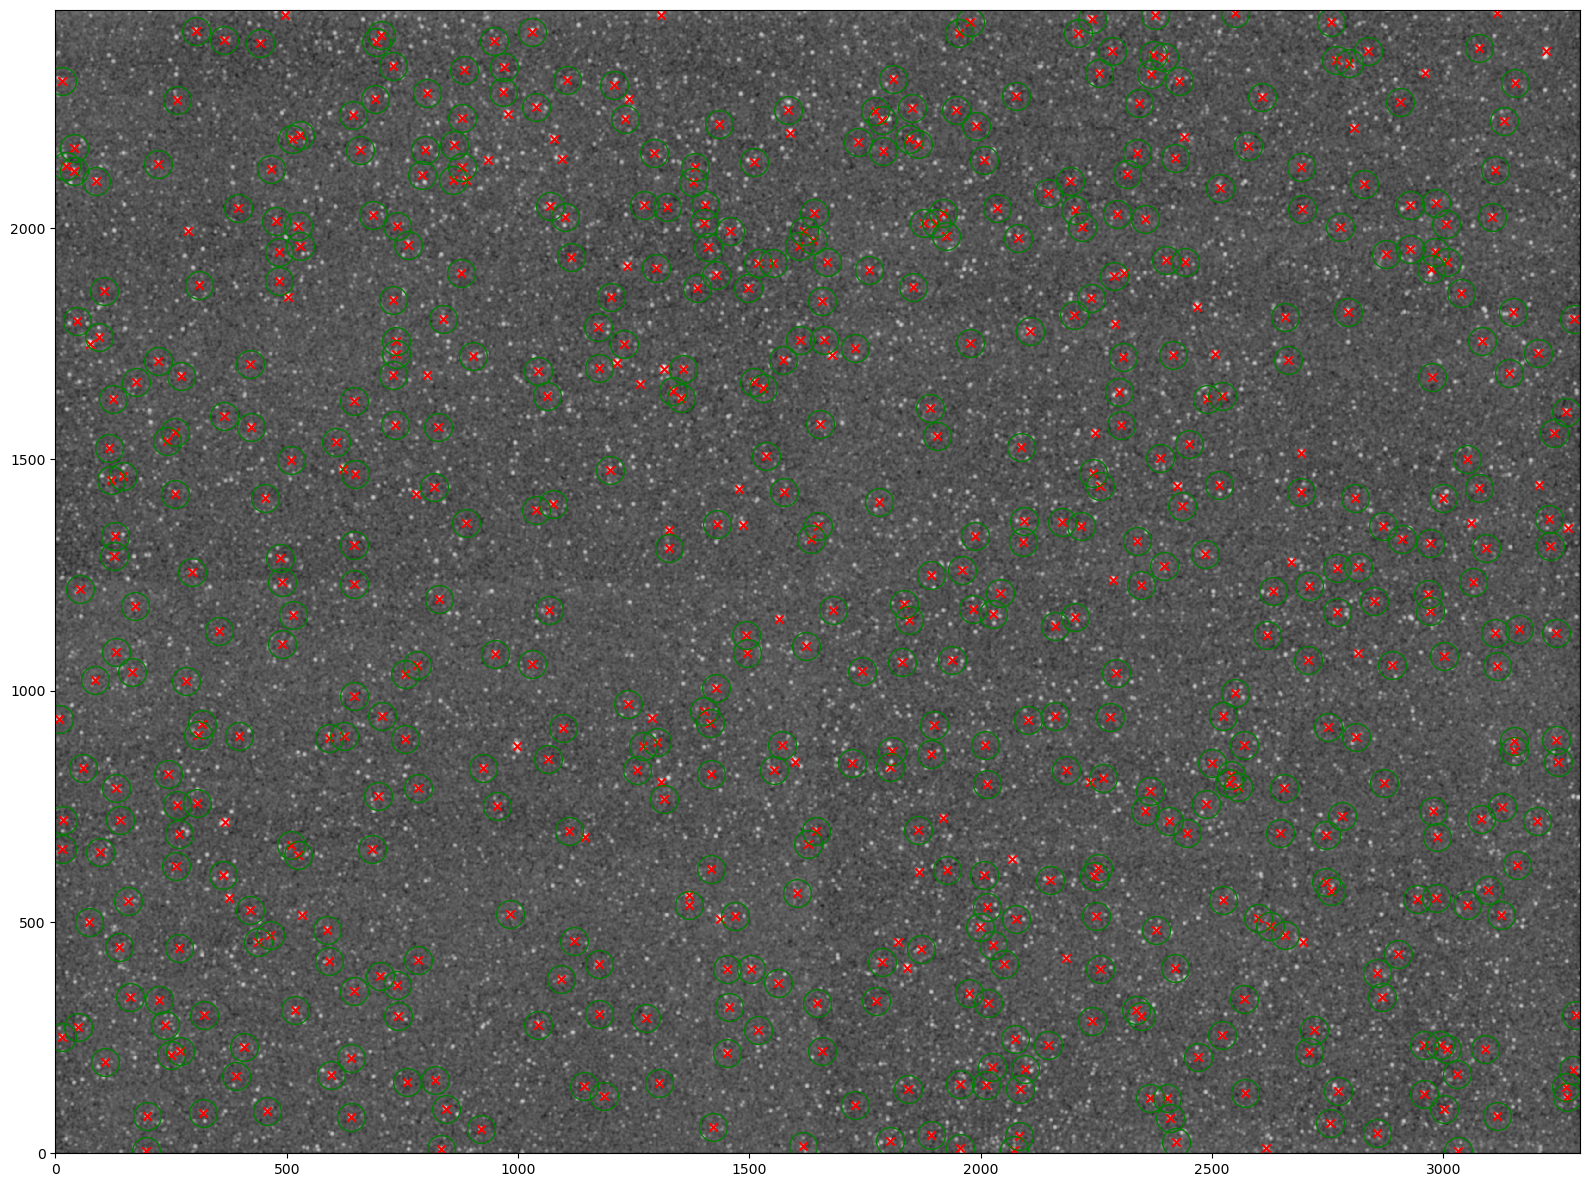

Got nan for ra/dec from visitInfo, using ra/dec from wcs...
Solving....Finished solving!
Image acceptable. Proceed.
Wrote /home/adriansh95/data/starTracker/tmaTests/wcsFits/pass/GC101_O_20221116_000014_solved.fits


In [29]:
imageAcceptable = True
exp = afwImage.ExposureF(fileName)
imArray = exp.image.array
mean = np.mean(imArray)
std = np.std(imArray)
plt.figure(figsize=(14, 14))

while imageAcceptable:
    plt.imshow(imArray, vmin=mean-2*std, vmax=mean+2*std)
    plt.colorbar(shrink=0.72)
    plt.show()
    saturatedStars = input('Do any sources look saturated? (y/n)')
    
    if saturatedStars == 'y':
        imageAcceptable = False
    elif saturatedStars == 'n':
        break
    else:
        print('Invalid input. (y/n)')
        continue

if imageAcceptable:
    nominalWcs = genericCameraHeaderToWcs(exp)
    exp.setWcs(nominalWcs)
    result = blindSolve(exp, radiusInDegrees=30, doPlot=True)
    newWcs = headerToWcs(result['astrometry_net_wcs_header'])
    exp.setWcs(newWcs)
    writeTo = os.path.join(passPath, f'{stemName}_solved.fits')
    print('Image acceptable. Proceed.')
else:
    print('Image unacceptable. Stop and explain failure')
    writeTo = os.path.join(failPath, f'{stemName}_unsolved.fits')
    
exp.writeFits(writeTo)
print(f'Wrote {writeTo}')

In [30]:
print(exp.wcs.getSkyOrigin())

(115.3713360511, -79.0152791477)


### Extract sources using Image Characterizer to construct and write a fits BINTable to send to astrometry.net
### independently to verify the solve

In [21]:
snr, minPix = 5, 25
imCharResult = runImchar(exp, snr, minPix)
solver = CommandLineSolver(indexFiles='/scratch/mfisherlevine/astrometry_net/broiler.astrometry.net/~dstn/4100',
                           checkInParallel=True)
newWcs = solver.run(exp, imCharResult.sourceCat, silent=True)

(null): Error reading magic number from Netpbm image stream.  Most often, this means your input file is empty.
(null): Error reading magic number from Netpbm image stream.  Most often, this means your input file is empty.


Found solution in 2.05 seconds


In [22]:
newWcs.getSkyOrigin()

SpherePoint(105.2227390134664*degrees, -77.66259424615484*degrees)